# Goal: Investigating a Drop in User Engagement

__About Yammer__: Yammer is a social network for communicating with coworkers. Individuals share documents, updates, and ideas by posting them in groups. Yammer is free to use indefinitely, but companies must pay license fees if they want access to administrative controls, including integration with user management systems like ActiveDirectory

__Problem__: You show up to work Tuesday morning, September 2, 2014. The head of the Product team
walks over to your desk and asks you what you think about the latest activity on the user
engagement dashboards. 
The chart shows the number of engaged users each week. Yammer defines engagement
as having made some type of server call by interacting with the product (shown in the data as
events of type “engagement”). Any point in this chart can be interpreted as “the number of users
who logged at least one engagement event during the week starting on that date.”
You are responsible for determining what caused the dip at the end of the chart shown above
and, if appropriate, recommending solutions for the problem.
    

__Hypothesis__:
    
1. Holidays affected this drop
2. App or web or device problem
3. Code is broken for specific event log or specific location/region

__Import all libraries and dependencies__

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import dates
from datetime import datetime
import random
import mysql.connector as mysql
import pandasql as ps
from pandasql import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
#read data

# Input Dataset for the Model

def ReadFromCSV(FilePath, sckipLines = 0, sep = ','):  

    #Read and clean the csv file in FilePath ignoring the first sckipLines lines.

    #(omits non-ascii characters from columns' name)

    xa = pd.read_csv(FilePath, header=sckipLines, sep = sep, low_memory=False, index_col=False)

    return xa

__Table 1__ : __Users Table__: includes one row per user, with descriptive information about that user's account

In [3]:
users=ReadFromCSV('/Users/mojganmazouchi/Desktop/Yammer/Insight_Datachallanges_2019/data/yammer_users.csv') 


print(users.shape)  #(19066, 5)

#df=df.drop(['Index'],axis=1)
users.head()

(19066, 6)


,user_id,created_at,company_id,language,activated_at,state
0,0.0,2013-01-01 20:59:39,5737.0,english,2013-01-01 21:01:07,active
1,1.0,2013-01-01 13:07:46,28.0,english,NaN,pending
2,2.0,2013-01-01 10:59:05,51.0,english,NaN,pending
3,3.0,2013-01-01 18:40:36,2800.0,german,2013-01-01 18:42:02,active
4,4.0,2013-01-01 14:37:51,5110.0,indian,2013-01-01 14:39:05,active


__Table 2__: __Events__:This table inlcudes one row per event, where an event is an action that a user has taken on Yammer These events include login events, messaging events, search events, events logged as users progress through a sign up funnel, events arround recieved emails.

In [4]:
events=ReadFromCSV('/Users/mojganmazouchi/Desktop/Yammer/Insight_Datachallanges_2019/data/yammer_events.csv') 

print(events.shape)  #(340,832, 7)

events['occurred_at_p']=pd.to_datetime(events['occurred_at'])
events['occurred_at_p'] = events['occurred_at_p'].dt.to_period(freq = 'W')
events['start_period'] = events.occurred_at_p.dt.start_time
events['end_period'] = events.occurred_at_p.dt.end_time

events=events.drop(['user_type','occurred_at_p'],axis=1)
events.head()

(340832, 7)


,user_id,occurred_at,event_type,event_name,location,device,start_period,end_period
0,10522.0,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook,2014-04-28,2014-05-04 23:59:59.999999999
1,10522.0,2014-05-02 11:02:53,engagement,home_page,Japan,dell inspiron notebook,2014-04-28,2014-05-04 23:59:59.999999999
2,10522.0,2014-05-02 11:03:28,engagement,like_message,Japan,dell inspiron notebook,2014-04-28,2014-05-04 23:59:59.999999999
3,10522.0,2014-05-02 11:04:09,engagement,view_inbox,Japan,dell inspiron notebook,2014-04-28,2014-05-04 23:59:59.999999999
4,10522.0,2014-05-02 11:03:16,engagement,search_run,Japan,dell inspiron notebook,2014-04-28,2014-05-04 23:59:59.999999999


In [5]:
# Plotting Weekly active users (#of users who logged at least one engagement during week start_period)
engaged = events[events['event_type'] == "engagement"]

engaged.head() #(321575, 8)

engaged_users = engaged.groupby('start_period')['user_id'].nunique().to_frame().reset_index()
engaged_users.head()

,start_period,user_id
0,2014-04-28,701
1,2014-05-05,1054
2,2014-05-12,1094
3,2014-05-19,1147
4,2014-05-26,1113


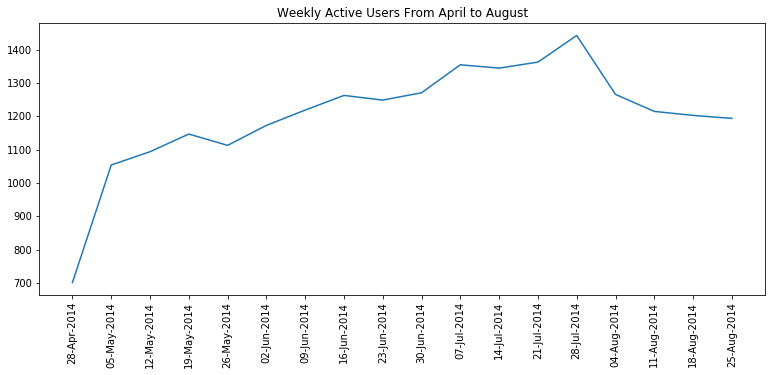

In [6]:
# Plotting
fig = plt.subplots(1,1, figsize = (13, 5))
ax = sns.lineplot(data=engaged_users, x="start_period", y="user_id")
ax.set(xticks=engaged_users.start_period.values);
ax.xaxis.set_major_formatter(dates.DateFormatter("%d-%b-%Y"));
plt.xticks(rotation=90);
plt.xlabel("");
plt.ylabel("");
plt.title("Weekly Active Users From April to August");

There is a drop seen after July 28, 2014, what are the __possible causes for the dip__ in retention shown in the plot above?

__Table 3__: Email Events This table contains events specific to the sending of e.mails. It is similar in structure to the events

In [7]:
emails=ReadFromCSV('/Users/mojganmazouchi/Desktop/Yammer/Insight_Datachallanges_2019/data/yammer_emails.csv') 

print(emails.shape)  #(90389, 4)

#df=df.drop(['Index'],axis=1)
emails.head()

(90389, 4)


,user_id,occurred_at,action,user_type
0,0.0,2014-05-06 09:30:00,sent_weekly_digest,1.0
1,0.0,2014-05-13 09:30:00,sent_weekly_digest,1.0
2,0.0,2014-05-20 09:30:00,sent_weekly_digest,1.0
3,0.0,2014-05-27 09:30:00,sent_weekly_digest,1.0
4,0.0,2014-06-03 09:30:00,sent_weekly_digest,1.0


__Table 4__: __Rollup Periods__
This table is a look up table that is used to create rolling time periods. 

In [8]:
roll=ReadFromCSV('/Users/mojganmazouchi/Desktop/Yammer/Insight_Datachallanges_2019/data/dimension_rollup_periods.csv') 

print(roll.shape)  #(56002, 6)

#df=df.drop(['Index'],axis=1)
roll.head()

(56002, 6)


,period_id,time_id,pst_start,pst_end,utc_start,utc_end
0,1.0,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-02 00:00:00,2013-01-01 08:00:00,2013-01-02 08:00:00
1,1.0,2013-01-02 00:00:00,2013-01-02 00:00:00,2013-01-03 00:00:00,2013-01-02 08:00:00,2013-01-03 08:00:00
2,1.0,2013-01-03 00:00:00,2013-01-03 00:00:00,2013-01-04 00:00:00,2013-01-03 08:00:00,2013-01-04 08:00:00
3,1.0,2013-01-04 00:00:00,2013-01-04 00:00:00,2013-01-05 00:00:00,2013-01-04 08:00:00,2013-01-05 08:00:00
4,1.0,2013-01-05 00:00:00,2013-01-05 00:00:00,2013-01-06 00:00:00,2013-01-05 08:00:00,2013-01-06 08:00:00


Digging in by dividing dataframe into to halves, before dip happens and after dip happens, to check how each user segment like country, app, device got affected. 

In [9]:
print ('events Distribution and Values:',events['event_type'].value_counts().to_dict())

events Distribution and Values: {'engagement': 321575, 'signup_flow': 19257}


In [10]:
# Dataframe division into two segments
event_before_dip = events[(events['start_period'] <= '2014-07-28')]
event_after_dip = events[(events['start_period'] > '2014-07-28')]

In [11]:
print ('events Distribution and Values before dip:',event_before_dip['event_type'].value_counts().to_dict())
print ('events Distribution and Values after dip:',event_after_dip['event_type'].value_counts().to_dict())

events Distribution and Values before dip: {'engagement': 254298, 'signup_flow': 14304}
events Distribution and Values after dip: {'engagement': 67277, 'signup_flow': 4953}


In [12]:
# Plotting Weekly signup_flow
signedup = events[events['event_type'] == "signup_flow"]

signedup_users = signedup.groupby('start_period')['user_id'].nunique().to_frame().reset_index()
signedup_users.head()

,start_period,user_id
0,2014-04-28,171
1,2014-05-05,350
2,2014-05-12,362
3,2014-05-19,371
4,2014-05-26,366


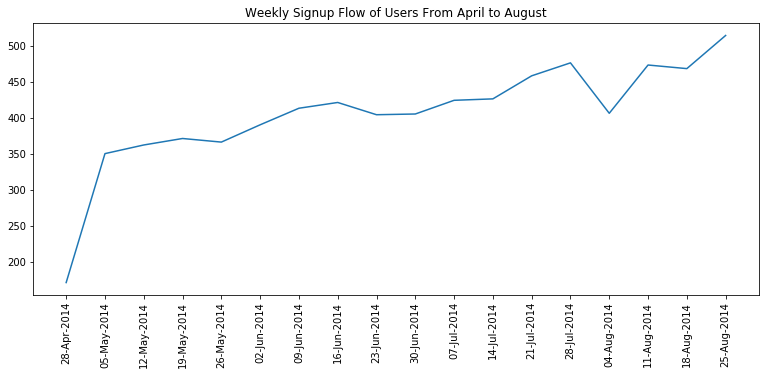

In [13]:
# Plotting
fig = plt.subplots(1,1, figsize = (13, 5))
ax = sns.lineplot(data=signedup_users, x="start_period", y="user_id")
ax.set(xticks=signedup_users.start_period.values);
ax.xaxis.set_major_formatter(dates.DateFormatter("%d-%b-%Y"));
plt.xticks(rotation=90);
plt.xlabel("");
plt.ylabel("");
plt.title("Weekly Signup Flow of Users From April to August");

Check if there is any unexpected reduction for sign up flow in any country

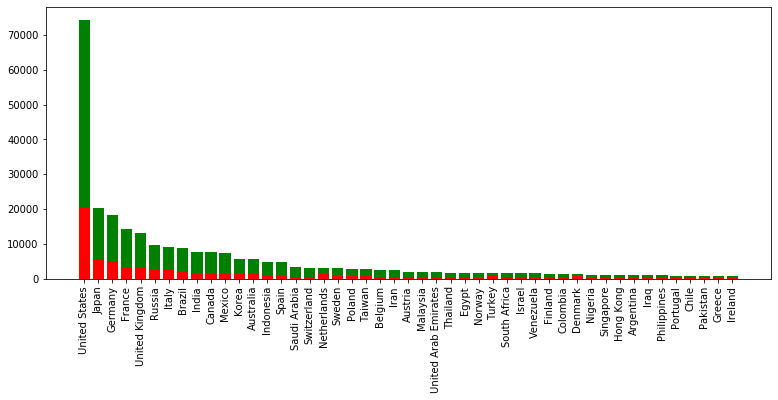

In [14]:
location_before_dip=event_before_dip['location'].value_counts().to_dict()
location_after_dip=event_after_dip['location'].value_counts().to_dict()

fig = plt.subplots(1,1, figsize = (13, 5))
plt.bar(list(location_before_dip.keys()), location_before_dip.values(), color='g')
plt.bar(list(location_after_dip.keys()), location_after_dip.values(), color='r')
plt.xticks(rotation=90);
plt.show()

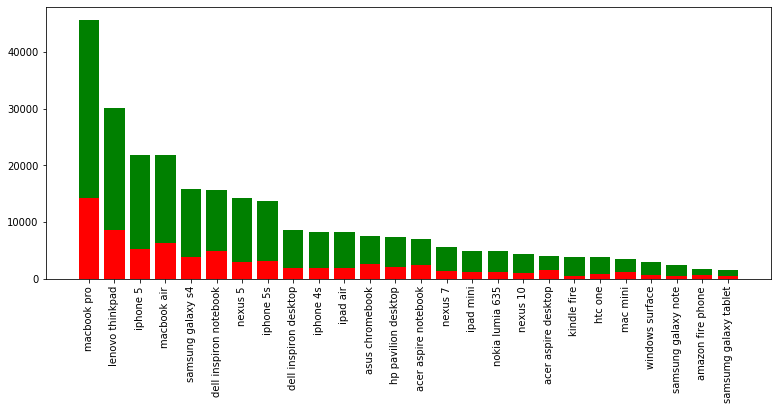

In [15]:
location_before_dip=event_before_dip['device'].value_counts().to_dict()
location_after_dip=event_after_dip['device'].value_counts().to_dict()

fig = plt.subplots(1,1, figsize = (13, 5))
plt.bar(list(location_before_dip.keys()), location_before_dip.values(), color='g')
plt.bar(list(location_after_dip.keys()), location_after_dip.values(), color='r')
plt.xticks(rotation=90);
plt.show()

# Weekly Engagement by Device Category

In [16]:
engaged_pc=engaged.loc[engaged['device'].isin(['macbook pro','lenovo thinkpad','macbook air','dell inspiron desktop','asus chromebook','hp pavilion notebook','acer aspire desktop', 'windows surface'])]
engaged_phone=engaged.loc[engaged['device'].isin(['iphone 5','samsung galaxy s4','nexus 5','iphone 5s','iphone 4s','nexus 7','nokia lumia 635', 'nexus 10','htc one','samsung galaxy note'])]
engaged_tablet=engaged.loc[engaged['device'].isin(['dell inspiron notebook','asus chromebook','acer notebook','ipad mini','kindle fire','mac mini','samsung galaxy tablet'])]

engaged_users_pc = engaged_pc.groupby('start_period')['user_id'].nunique().to_frame().reset_index()
engaged_users_phone = engaged_phone.groupby('start_period')['user_id'].nunique().to_frame().reset_index()
engaged_users_tablet = engaged_tablet.groupby('start_period')['user_id'].nunique().to_frame().reset_index()


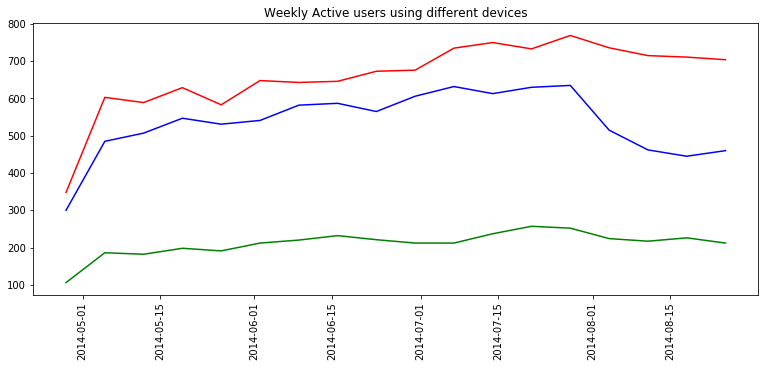

In [17]:
# Plotting
fig = plt.subplots(1,1, figsize = (13, 5))
plt.plot(engaged_users_pc['start_period'], engaged_users_pc['user_id'], 'r') # plotting t, a separately 
plt.plot(engaged_users_phone['start_period'], engaged_users_phone['user_id'], 'b') # plotting t, b separately 
plt.plot(engaged_users_tablet['start_period'], engaged_users_tablet['user_id'], 'g') # plotting t, c separately 
ax.set(xticks=engaged_users_pc.start_period.values);
ax.xaxis.set_major_formatter(dates.DateFormatter("%d-%b-%Y"));
plt.xticks(rotation=90);
plt.xlabel("");
plt.ylabel("");
plt.title("Weekly Active users using different devices");

There is a huge drop in engagement for phone users
Let's check for __different operating systems ios vs android vs windows phone__


In [21]:
engaged_ios=engaged_phone.loc[engaged_phone['device'].isin(['iphone 5','iphone 5s','iphone 4s'])]
engaged_android=engaged_phone.loc[engaged_phone['device'].isin(['samsung galaxy s4','nexus 5','nexus 7', 'nexus 10','htc one','samsung galaxy note'])]
engaged_windows=engaged_phone.loc[engaged_phone['device'].isin(['nokia lumia 635'])]

engaged_users_ios = engaged_ios.groupby('start_period')['user_id'].nunique().to_frame().reset_index()
engaged_users_android = engaged_android.groupby('start_period')['user_id'].nunique().to_frame().reset_index()
engaged_users_windows = engaged_windows.groupby('start_period')['user_id'].nunique().to_frame().reset_index()



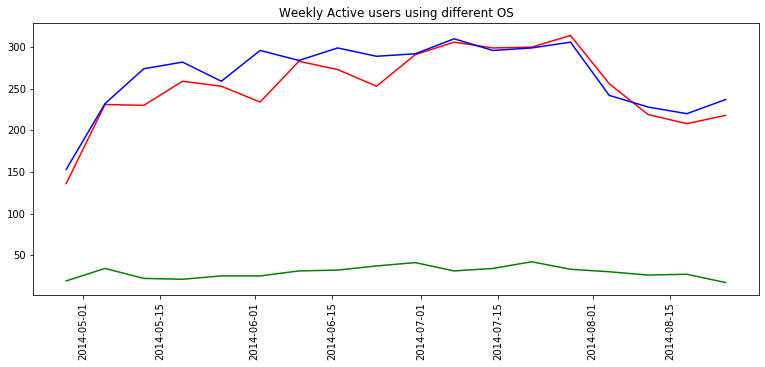

In [22]:
# Plotting
fig = plt.subplots(1,1, figsize = (13, 5))
plt.plot(engaged_users_ios['start_period'], engaged_users_ios['user_id'], 'r') # plotting t, a separately 
plt.plot(engaged_users_android['start_period'], engaged_users_android['user_id'], 'b') # plotting t, b separately 
plt.plot(engaged_users_windows['start_period'], engaged_users_windows['user_id'], 'g') # plotting t, c separately 

ax.set(xticks=engaged_users_pc.start_period.values);
ax.xaxis.set_major_formatter(dates.DateFormatter("%d-%b-%Y"));
plt.xticks(rotation=90);
plt.xlabel("");
plt.ylabel("");
plt.title("Weekly Active users using different OS");

__1st Take away__: It’s likely that there’s a problem with the mobile app espacially with ios and Android os related to long-time user retention.

In [25]:
emails['action'].value_counts().to_dict()
emails['occurred_at_p']=pd.to_datetime(emails['occurred_at'])
emails['occurred_at_p'] = emails['occurred_at_p'].dt.to_period(freq = 'W')
emails['start_period'] = emails.occurred_at_p.dt.start_time
emails['end_period'] = emails.occurred_at_p.dt.end_time

emails=emails.drop(['user_type','occurred_at_p'],axis=1)

In [26]:
email_sent_weekly=emails.loc[emails['action'].isin(['sent_weekly_digest'])]
email_open=emails.loc[emails['action'].isin(['email_open'])]
email_ct=emails.loc[emails['action'].isin(['email_clickthrough'])]
email_sent_reengagement=emails.loc[emails['action'].isin(['sent_reengagement_email'])]

email_sent_weekly_u = email_sent_weekly.groupby('start_period')['user_id'].nunique().to_frame().reset_index()
email_open_u = email_open.groupby('start_period')['user_id'].nunique().to_frame().reset_index()
email_ct_u = email_ct.groupby('start_period')['user_id'].nunique().to_frame().reset_index()
email_sent_reengagement_u = email_sent_reengagement.groupby('start_period')['user_id'].nunique().to_frame().reset_index()


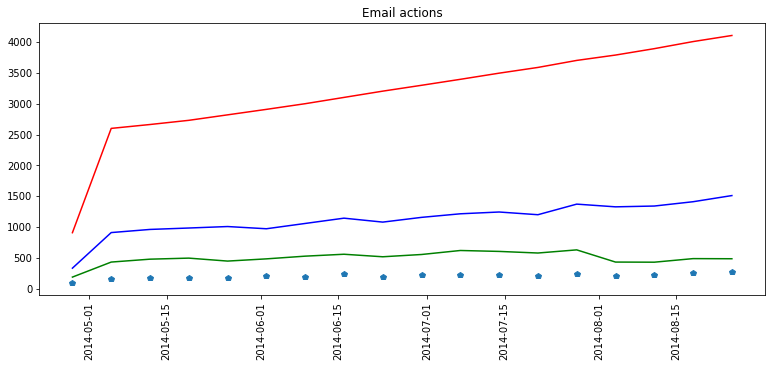

In [28]:
# Plotting
fig = plt.subplots(1,1, figsize = (13, 5))
plt.plot(email_sent_weekly_u['start_period'], email_sent_weekly_u['user_id'], 'r') # plotting t, a separately 
plt.plot(email_open_u['start_period'], email_open_u['user_id'], 'b') # plotting t, b separately 
plt.plot(email_ct_u['start_period'], email_ct_u['user_id'], 'g') # plotting t, c separately 
plt.plot(email_sent_reengagement_u['start_period'], email_sent_reengagement_u['user_id'], 'p') # plotting t, c separately 


ax.set(xticks=engaged_users_pc.start_period.values);
ax.xaxis.set_major_formatter(dates.DateFormatter("%d-%b-%Y"));
plt.xticks(rotation=90);
plt.xlabel("");
plt.ylabel("");
plt.title("Email actions");

From the plot above clickthroughs are way down.

__2nd Take away__: There is a problem associated with email clickthrought 

# Summary

After investigation, it appears that the problem has to do with mobile use (ios and android users) and clickthough emails.
Notify the stakeholders and let them know something isn’t broken or poorly implemented. The above plots suggest the mobile users and e.mail clickthrough are the area they need to focus on.